<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
rng_date    3650 non-null datetime64[ns]
temp        3647 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.1 KB


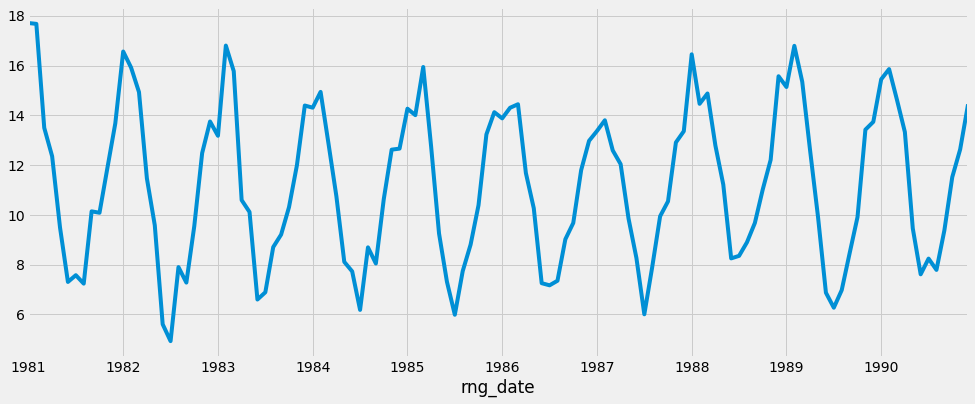

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:723.2138067298466
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:269.127940570641
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:367.1621034921775
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:319.42331966850037
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:295.9745459291065
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:275.30648955647706
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:772.326039531656
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:612.8692386386116
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:359.2296927446423
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:259.6311465704184
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:367.97503041159916
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:308.2255476125986
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:296.2197624438826
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:269.8131382744146
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 -

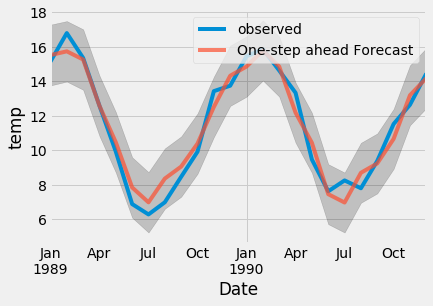

The Mean Squared Error of our forecasts is 0.54


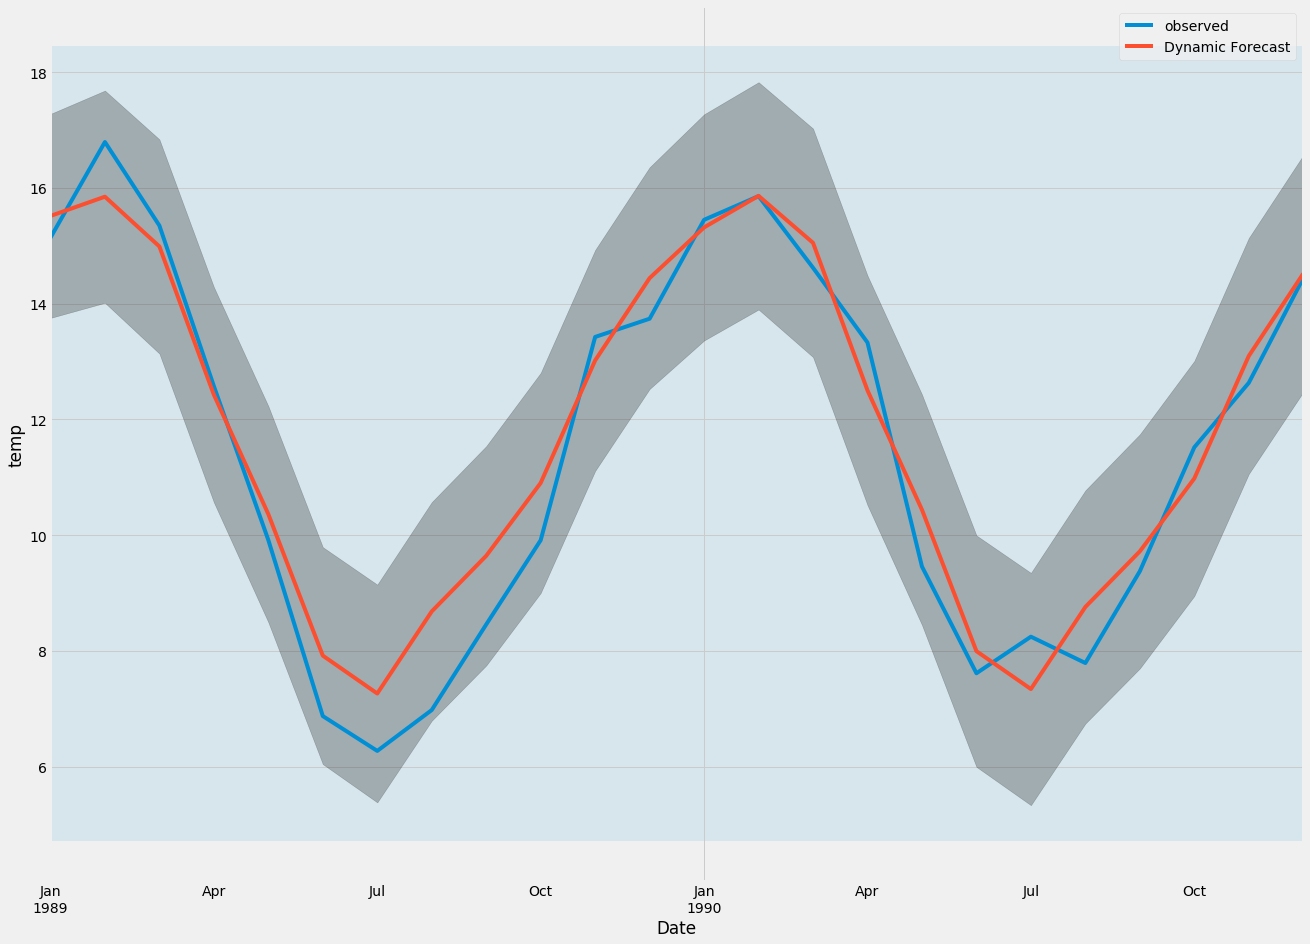

The Mean Squared Error of our forecasts is 0.57


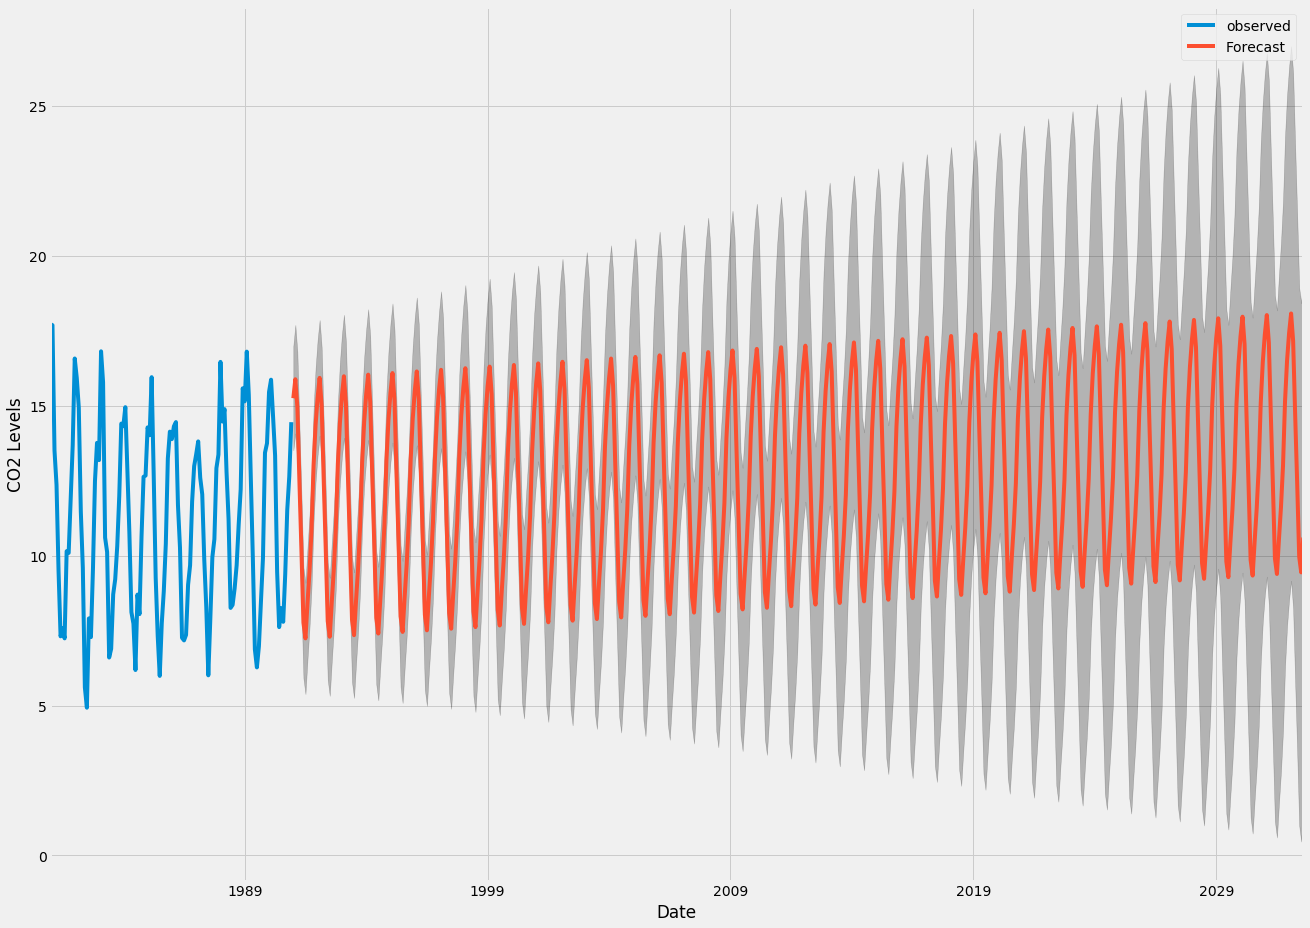

In [111]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""

# check working directory
import os
os.getcwd()
# set working directory
os.chdir('C:\\Users\\shafin.mohammad\\pythondata')
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# read file
dataset=pd.read_csv('dailyminimumtemperaturesinme.csv',header=0,delimiter=',')
# create date range with compatible datetime 
dataset['rng_date'] = pd.date_range('1/1/1981', periods=3650, freq='d')
# typecast temp to float 
dataset.temp = pd.to_numeric(dataset.temp,errors='coerce')

# drop old date column
dataset = dataset.drop(['Date'], axis=1)
#reformat table structure
dataset = dataset[['rng_date', 'temp']]
dataset.info()
dataset.rng_date = pd.to_datetime(dataset.rng_date)

dataset.index = pd.to_datetime(dataset.rng_date)
# The 'MS' string groups the data in buckets by start of the month
dataset = dataset['temp'].resample('MS').mean()

# The term bfill means that we use the value before filling in missing values
dataset = dataset.fillna(dataset.bfill())

# plot actuals
# Let's explore this time series e as a data visualization:
dataset.plot(figsize=(15, 6))
plt.show()

#ARIMA
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

# grid search
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dataset,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

# Step 5 — Fitting an ARIMA Time Series Model
# Using grid search, we have identified the set of parameters 
# that produces the best fitting model to our time series data. We can proceed
# to analyze this particular model in more depth.

# We'll start by plugging the optimal parameter values into a new SARIMAX model:
mod = sm.tsa.statespace.SARIMAX(dataset,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

# validating forecast
pred = results.get_prediction(start=pd.to_datetime('1989-01-01'), dynamic=False)
pred_ci = pred.conf_int()

# We can plot the real and forecasted values of the CO2 time series to assess how well we did. Notice how we zoomed in on the end of the time series by slicing the date index.
ax = dataset['1989':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('temp')
plt.legend()

plt.show()

#mean squared error 1 step
dataset_forecasted = pred.predicted_mean
dataset_truth = dataset['1989-01-01':]

# Compute the mean square error
mse = ((dataset_forecasted - dataset_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# dynamic mse
pred_dynamic = results.get_prediction(start=pd.to_datetime('1989-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = dataset['1989':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1989-01-01'), dataset.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('temp')

plt.legend()
plt.show()

# Extract the predicted and true values of our time series
dataset_forecasted = pred_dynamic.predicted_mean
dataset_truth = dataset['1989-01-01':]

# Compute the mean square error
mse = ((dataset_forecasted - dataset_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = dataset.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()
